*** This script runs the previously built permit subtype Naive Bayes classifiers to perform evaluation on the previously curated permit dataset. ***


General declarations, including used libraries, support and plotting packages.
Python version 2.7+ must be installed along with the following packages:
os (built-in), numpy, pandas, nltk (Natural Language Processing Toolkit), codecs, sklearn (statistical learning package), mpld3, MySQLdb, pylab, csv, string, matplotlib (plotting), seaborn (plotting), pickle (to save clusters and other data objects).

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import MySQLdb
import pandas.io.sql as sql
import matplotlib.pyplot as plt
import pylab as py
import csv
import string
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from pystruct.learners import NSlackSSVM
from pystruct.models import MultiLabelClf
from collections import defaultdict

import seaborn as sns
import pickle

sns.set(style="white", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

stopwords=set(unicode("john american james hbcode thomas david michael robert subtype richard permit building none america rochester william needs brother jessica give like send estimate im youre chat details regarding hi available email call please interested contact looking project need job phone work so some somebody somehow someone something sometime sometimes somewhat somewhere soon sorry specified specify specifying still sub such sup sure t's take taken tell tends th than thank thanks thanx that that's thats the their theirs them themselves then thence there there's thereafter thereby therefore therein theres thereupon these they they'd they'll they're they've think third this thorough thoroughly those though three through throughout thru thus to together too took toward towards tried tries truly try trying twice two un under unfortunately unless unlikely until unto up upon us use used useful uses using usually value various very via viz vs want wants was wasn't way we we'd we'll we're we've welcome well went were weren't what what's whatever when whence whenever where where's whereafter whereas whereby wherein whereupon wherever whether which while whither who who's whoever whole whom whose why will willing wish with within without won't wonder would wouldn't yes yet you you'd you'll you're you've your yours yourself yourselves zero a about above after again against all am an and any are aren't as at be because been before being below between both but by can can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on one once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves").split())


General functions for reading data, doing cluster to keyword mapping and text pre-processing.

In [3]:
# Function to read the raw text from the curated building permit sample files
# Input: input_file, which is simply a string with the file name
# Output: list where each element is the raw text from each building permit. 
def read_curated(input_file):
    text=[]
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\t')
        # For each row in the file, read the job_values and the associated strings. 
        for row in reader:
            text.append(' '.join(row))
    return text

# Function to read words associated to permit subtypes
# Input: file_name
# Output: list of identifier for each trade/permit type (label), list of 'synonym' words for each permit subtype. 
def read_words(input_file):
    label=[]
    words=[]
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\n')
        # For each row in the file, read the job_values and the associated strings. 
        for row in reader:
            row=row[0].split(',')
            label.append(row.pop(0))
            temp=[]
            for x in row:
                x=x.lower()
                x=x.replace('"','')
                x=x.replace(' ','')
                if x != '':
                    temp.append(x)
            words.append(temp)
    return label,words

# Function to join text for a given list. 
# Inputs: list with strings
def join_txt(x):
    content = ' '.join(filter(None,x))
    return content

# Text pre-processing function, that also applies the Snowball stemmer to each word
# This function's only difference compared to content2tokens is the use of the stemmer. 
# Filter out spaces, punctuation, unnecessary whitespaces. 
# Any stop-word is also removed
# Additionally, this function also removes any word smaller than 4 characters
# Inputs: list with string for each building permit
def content2stems(s):
    # Initialize Snowball stemmer
    stemmer = SnowballStemmer("english")
    # Transform all letters to lower-case
    content = s.lower()
    # Remove periods
    content = content.replace('.', ' ')    
    # Split words
    content = ' '.join(content.split())
    # Remove punctuation
    for c in content:
        if c in string.punctuation or c.isdigit():
            content=content.replace(c," ")
    
    # Split words into a list
    content = content.split() 
    # Filter words from the stoplist
    content = filter(lambda w: w not in stopwords, content)  
    # Filter words smaller than 3 characters
    content = filter(lambda w: len(w) > 3, content)
    # Apply Snowball stemmer to words
    content = [stemmer.stem(t) for t in content]    
    return content

Read "gold" standard testing set that was created earlier, to use as an evaluation metric for the classifiers that will be tested. 

This is the previously curated data.

In [4]:
# Read input files from curated data
build_permits=read_curated('./Curated_Permits/BPermit_Curated_Sample.tsv')
map_test=pd.DataFrame.from_csv('./Curated_Permits/Curated_Class_Labels.csv')

# Read building permit subtypes keywords and stem them.
keyword_label,keywords=read_words('taxonomy_cluster_keywords.csv')
# Turn all label subtypes to lower_case
keyword_label=map(lambda x: x.lower(),keyword_label)

Build the tf/idf for the classification.

In [5]:
# Open lexicon terms from a previously file. 
with open('NB_Classifiers/permit_terms.pickle') as f:
    terms= pickle.load(f)
    
# Remove the extra list from the terms object
terms=terms[0]

# Build tf/idf matrix
tfidf_vectorizer = TfidfVectorizer(vocabulary=terms, stop_words=stopwords,
                                   use_idf=True, tokenizer=content2stems,
                                   decode_error='ignore',ngram_range=[1,1])
tfidf_matrix = tfidf_vectorizer.fit_transform(build_permits)

# Also convert the permit labels (y, for the predictions) into a numpy array
map_test=np.array(map_test)

Run the Naive Bayes_Classifiers to classify the building permit curated test set

In [6]:
scores_indiv=[]
classification=[]
total_error=[]
# Run the Naive Bayes classifier for each subtype
for i, key in enumerate(keyword_label):
    # Read the NB classifiers
    cls=joblib.load('./NB_Classifiers/NB_'+str(key)+'.pkl')
    
    sample_test= map_test[:,i]
    
    # Score the predicted accuracy when comparing to the "ground truth"
    score=cls.score(tfidf_matrix, sample_test, sample_weight=None)
    total_error=(1-score)*len(build_permits)
    scores_indiv.append(score)
    
    # Run the classifiers across the testing set and save the result
    classification.append(cls.predict(tfidf_matrix))

# Calculate total error (i.e. errors across all subtypes/total number of classifications)
total_error=total_error/(len(build_permits)*len(keyword_label))

# Calculate error when classifying across the whole range of features 
# (i.e. that all features for a given permit were correctly classified)
classification=np.array(classification)
classification=np.matrix.transpose(classification)

compare_test=zip(classification,map_test)
classification_error=map(lambda x: 1 if not np.array_equal(x[0],x[1]) else 0, compare_test)
classification_error=float(np.array(classification_error).sum())/len(sample_test)

# Convert classification list to pandas dataframe
classification=pd.DataFrame(classification,columns=keyword_label)

In [9]:
# Classification acccuracy when all subtypes are correctly evaluated
1-classification_error

0.8109748159422614

In [10]:
# Classification accuracy averaged across all subtypes individually
1-total_error

0.99994208322195488

Step done just to verify/play around with classification

In [11]:
m=815
t=np.where(classification.iloc[m,:]==1)[0]
for key in t:
    print(keyword_label[key])
    
print (build_permits[m])

carpentry
windows_doors
replacement
residential_home
815 824824 REPLACE 2 EXISTING WINDOW & FONT OF HOUSE WITH SHITE WOOD CLAD WINDOWS Building Permit  1 FAMILY DWELLING BARTLEY CONSTRUCTION 102 windows


Plot individual subtype prediction score (ranges from 0-worst to 1-perfect)

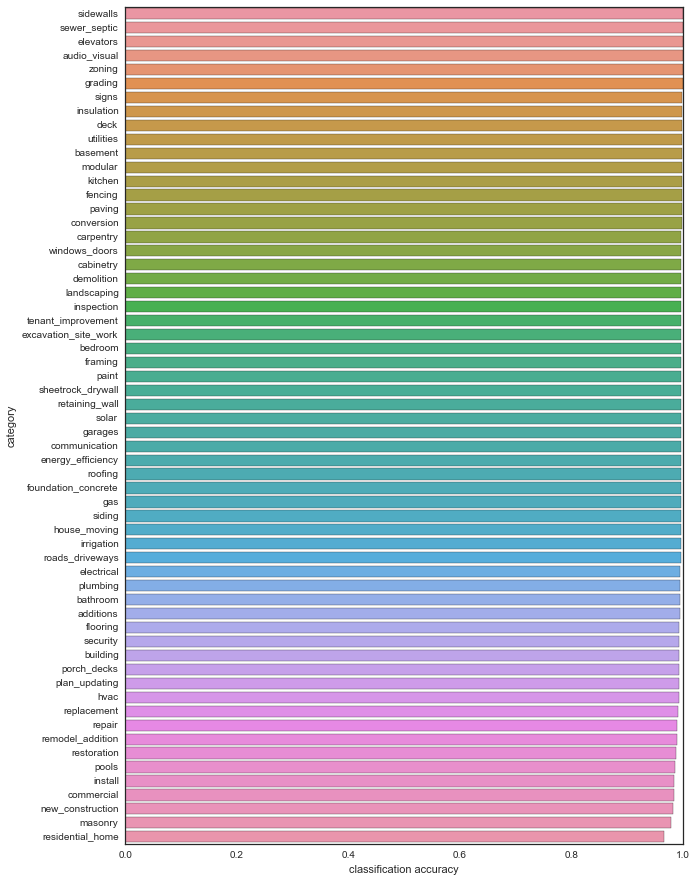

In [12]:
# Build plot for the classification errors across each permit subtype. 
scores_db = {'category': keyword_label, 'score': scores_indiv}
scores_db = pd.DataFrame(scores_db, index = range(0,len(keyword_label)) , columns = ['category','score'])
scores_db=scores_db.sort('score',ascending=False)
f, ax = plt.subplots(figsize=(10, 15))
sns.barplot(y="category", x="score", data=scores_db);
plt.xlabel('classification accuracy')
plt.savefig('./NB_Classifiers/Classification/NB_Subtype_Accuracy.png')

Print out the distribution for the classifications

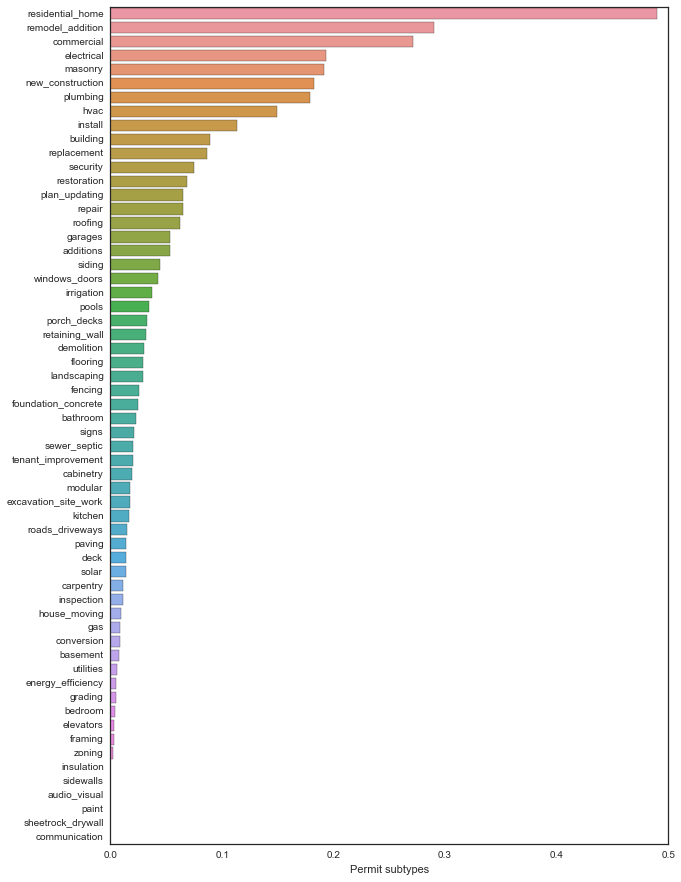

In [13]:
# Build showing the fraction of times each subtype appears in a building permit. 
f, ax = plt.subplots(figsize=(10, 15))
subtype_count=pd.DataFrame(classification.sum(axis=0),columns=['Count'])/len(build_permits)
subtype_count=subtype_count.sort(['Count'],ascending=False).transpose()
sns.barplot(data=subtype_count, orient='h');
plt.xlabel('Permit subtypes')
plt.savefig('./NB_Classifiers/Classification/BPermits_Sample_Classification.png')